## Online Payment Fraud Detection


Este trabajo consiste en cargar los datos de fraude y realizar un análisis completo, desde la visualización de los datos, hasta la imputación, ingeniería de características, modelo de ML y monitorización.

He tratado de automatizar los procesos dentro de funciones para que si se recibe un dataframe parecido, pueda al menos sacar un resumen de los datos y visualizaciones, asi como imputar datos faltantes. El entrenamiento del modelo ML también es automático.

La única parte no automatizada es la carga de datos y la ingeniería de características.

In [1]:
# Cargamos las librerias necesarias
#=========================================================================================
# Librerias generales
import numpy as np 
np.set_printoptions(suppress=True)
import pandas as pd 
pd.set_option('display.float_format', lambda x: '%.3f' % x)
import math

# Librerias de visualización
import matplotlib.pyplot as plt
import seaborn as sns


# Paralelización
import multiprocessing

# Librerias de ML
from sklearn.model_selection import RandomizedSearchCV, RepeatedKFold
from sklearn.ensemble import RandomForestClassifier
from sklearn.pipeline import Pipeline
from sklearn.preprocessing import StandardScaler, OneHotEncoder
from sklearn.compose import ColumnTransformer
from sklearn.model_selection import train_test_split
from sklearn.metrics import accuracy_score, roc_curve, auc
from sklearn.metrics import confusion_matrix
from sklearn.metrics import ConfusionMatrixDisplay
from sklearn.metrics import classification_report

# Librería de monitoring
import nannyml

C:\Users\josel\AppData\Local\Packages\PythonSoftwareFoundation.Python.3.11_qbz5n2kfra8p0\LocalCache\local-packages\Python311\site-packages\tqdm\auto.py:21: TqdmWarning: IProgress not found. Please update jupyter and ipywidgets. See https://ipywidgets.readthedocs.io/en/stable/user_install.html
  from .autonotebook import tqdm as notebook_tqdm


In [2]:
# Cargamos los datos
datos = pd.read_csv("fraud/fraud.csv")

Supongamos que la variable objetivo suele venir en los datos como 'fraud', 'fraude', 'isfraud'...
También que contiene dos niveles: 1 o 0. Si se cumplen estas dos condiciones, extraemos la columna como variable objetivo y si en los datos viniese cualquier otra columna que cumpla lo anterior, se prioriza una lista de posibles nombres de la variable objetivo. 

Aún asi puede complicarse el definir automaticamente la variable objetivo y hay que tener cuidado


In [3]:
# Función para encontrar la variable objetivo
def encontrar_variable_objetivo(df):
    columnas_prioritarias = ['isfraud', 'fraud', 'fraude','TARGET','target']  # Priorizar estas columnas
    for col in columnas_prioritarias:
        if col in df.columns:
            columna = df[col]
            if columna.nunique() == 2 and set(columna.unique()) == {0, 1}:
                return col
    
    # Si no se encuentra en las columnas prioritarias, buscar en todas las columnas
    for col in df.columns:
        col_lower = col.lower()
        if 'fraud' in col_lower or 'target' in col_lower:
            columna = df[col]
            if columna.nunique() == 2 and set(columna.unique()) == {0, 1}:
                return col
    
    return print('Se requiere establecer manualmente la variable objetivo')

In [4]:
v_obj = encontrar_variable_objetivo(datos)

### EDA

En el análisis exploratorio de datos se realiza una captura de información fundamental de la estructura de los datos, tipos de variables, estadísticas principales y valores ausentes.

Después, otra función extrae visualizaciones que pueden ser interesantes de cara al análisis, tanto de las variables numéricas, como las categóricas, así como la relación entre las variables dependientes y la variable objetivo, previamente definida en v_obj.

Las variables categoricas se representan si tienen menos de 20 niveles, ya que, por ejemplo representar la columna nameOrig sería absurdo.


In [38]:
# ------------------ FUNCIÓN DE RESUMEN GENERAL DE LOS DATOS -----------------------
def Resumen(datos):
    print("\nPrimeras filas de los datos")
    print(datos.head())
    
    print("\nTipo de cada columna")
    print(datos.info())

    print("\nEstadísticas")
    print(datos.describe())

    print("\nValores ausentes")
    print(datos.isna().sum().sort_values())
    
    print("\nNúmero de transacciones fraudulentas")
    print(datos[v_obj].sum())
    
# ------------------ FUNCIÓN DE VISUALIZACIÓN DE LOS DATOS -----------------------
def Visualizaciones(datos, v_obj):
    def graficar_columnas_categoricas(datos):
        print("Generando gráficos de distribución para variables categóricas con menos de 20 clases...")
        columnas_categoricas = datos.select_dtypes(include=['object', 'category']).columns
        columnas_categoricas = [col for col in columnas_categoricas if datos[col].nunique() < 20]

        for column in columnas_categoricas:
            fig, ax = plt.subplots(figsize=(8, 6))
            sns.countplot(data=datos, y=column, order=datos[column].value_counts().index, hue=column, palette='Set1', ax=ax, legend=False)
            ax.set_title(f'Distribución de {column}', fontsize=12, fontweight="bold")
            ax.set_xlabel('Count')
            ax.set_ylabel(column)
            plt.tight_layout()
            plt.show()

    def graficar_categoricas_con_objetivo(datos, v_obj):
        print(f"Generando gráficos de distribución por '{v_obj}' para variables categóricas con menos de 20 clases...")
        columnas_categoricas = datos.select_dtypes(include=['object', 'category']).columns
        columnas_categoricas = [col for col in columnas_categoricas if datos[col].nunique() < 20]

        for column in columnas_categoricas:
            fig, ax = plt.subplots(figsize=(10, 6))
            sns.countplot(data=datos, x=column, hue=v_obj, palette='Set1', ax=ax)
            ax.set_title(f'Fraud and Non-Fraud Transactions by {column}')
            ax.legend(title=v_obj, loc='upper right')
            ax.tick_params(axis='x', rotation=45)
            ax.set_xlabel('')
            
            for p in ax.patches:
                height = p.get_height()
                ax.annotate(f'{height}', (p.get_x() + p.get_width() / 2., height),
                            ha='center', va='bottom', fontsize=8, color='black', xytext=(0, 5),
                            textcoords='offset points')
            
            plt.tight_layout()
            plt.show()

    def graficar_boxplots(datos, v_obj):
        print(f"Generando boxplots por '{v_obj}' para variables numéricas...")
        columnas_numericas = datos.select_dtypes(include=['float64', 'int']).columns
        columnas_numericas = columnas_numericas.drop(v_obj)
    
        num_columnas = len(columnas_numericas)
        num_filas = math.ceil(num_columnas / 2)
    
        fig, axes = plt.subplots(nrows=num_filas, ncols=2, figsize=(12, 5*num_filas))
        axes = axes.flatten()
    
        for i, column in enumerate(columnas_numericas):
            ax = axes[i]
            sns.boxplot(data=datos, x=v_obj, y=column, hue=v_obj, palette='Set1', ax=ax, legend=False)
            ax.set_title(f'Boxplot de {column} por {v_obj}')
            ax.set_xlabel('')
            ax.set_ylabel(column)
            ax.xaxis.set_major_formatter(plt.FuncFormatter(lambda x, _: '{:,.0f}'.format(x)))  # Formatear el eje X sin notación científica
            ax.yaxis.set_major_formatter(plt.FuncFormatter(lambda x, _: '{:,.0f}'.format(x)))  # Formatear el eje Y sin notación científica
    
        for j in range(i + 1, len(axes)):
            fig.delaxes(axes[j])
    
        plt.tight_layout()
        plt.show()
        
    def graficar_histogramas(datos):
        print("Generando histogramas para variables numéricas...")
        columnas_numericas = datos.select_dtypes(include=['float64', 'int']).columns
        columnas_numericas = columnas_numericas.drop(v_obj)
        
        num_columnas = len(columnas_numericas)
        num_filas = math.ceil(num_columnas / 2)
    
        fig, axes = plt.subplots(nrows=num_filas, ncols=2, figsize=(16, 6*num_filas))
        axes = axes.flatten()
    
        for i, column in enumerate(columnas_numericas):
            ax = axes[i]
            ax.hist(datos[column], bins=30, color='skyblue', edgecolor='black')
            ax.set_title(f'Histograma de {column}')
            ax.set_xlabel(column)
            ax.set_ylabel('Frecuencia')
            ax.xaxis.set_major_formatter(plt.FuncFormatter(lambda x, _: '{:,.0f}'.format(x)))  # Formatear el eje X sin notación científica
            ax.yaxis.set_major_formatter(plt.FuncFormatter(lambda x, _: '{:,.0f}'.format(x)))  # Formatear el eje Y sin notación científica
            ax.tick_params(axis='x', rotation=45)    
        for j in range(i + 1, len(axes)):
            fig.delaxes(axes[j])
    
        plt.tight_layout()
        plt.show()

    graficar_histogramas(datos)
    graficar_columnas_categoricas(datos)
    graficar_categoricas_con_objetivo(datos, v_obj)
    graficar_boxplots(datos, v_obj)
           

In [28]:
Resumen(datos)


Primeras filas de los datos
   step      type    amount     nameOrig  oldbalanceOrg  newbalanceOrig  \
0     1   PAYMENT  9839.640  C1231006815     170136.000      160296.360   
1     1   PAYMENT  1864.280  C1666544295      21249.000       19384.720   
2     1  TRANSFER   181.000  C1305486145        181.000           0.000   
3     1  CASH_OUT   181.000   C840083671        181.000           0.000   
4     1   PAYMENT 11668.140  C2048537720      41554.000       29885.860   

      nameDest  oldbalanceDest  newbalanceDest  isFraud  isFlaggedFraud  
0  M1979787155           0.000           0.000        0               0  
1  M2044282225           0.000           0.000        0               0  
2   C553264065           0.000           0.000        1               0  
3    C38997010       21182.000           0.000        1               0  
4  M1230701703           0.000           0.000        0               0  

Tipo de cada columna
<class 'pandas.core.frame.DataFrame'>
RangeIndex: 6362

Del resumen general de los datos vemos como el dataset no tiene ningún valor faltante. Las cuentas de balance, ya sea cualquiera de las disponibles, presentan valores muy heterogéneos, por lo que es posible que encontremos muchos valores atípicos a ser la distribución tan amplia, desde balances con 0 hasta superar los 50 millones.

El total de casos fraudulentos en este dataset es de 8213


Generando histogramas para variables numéricas...


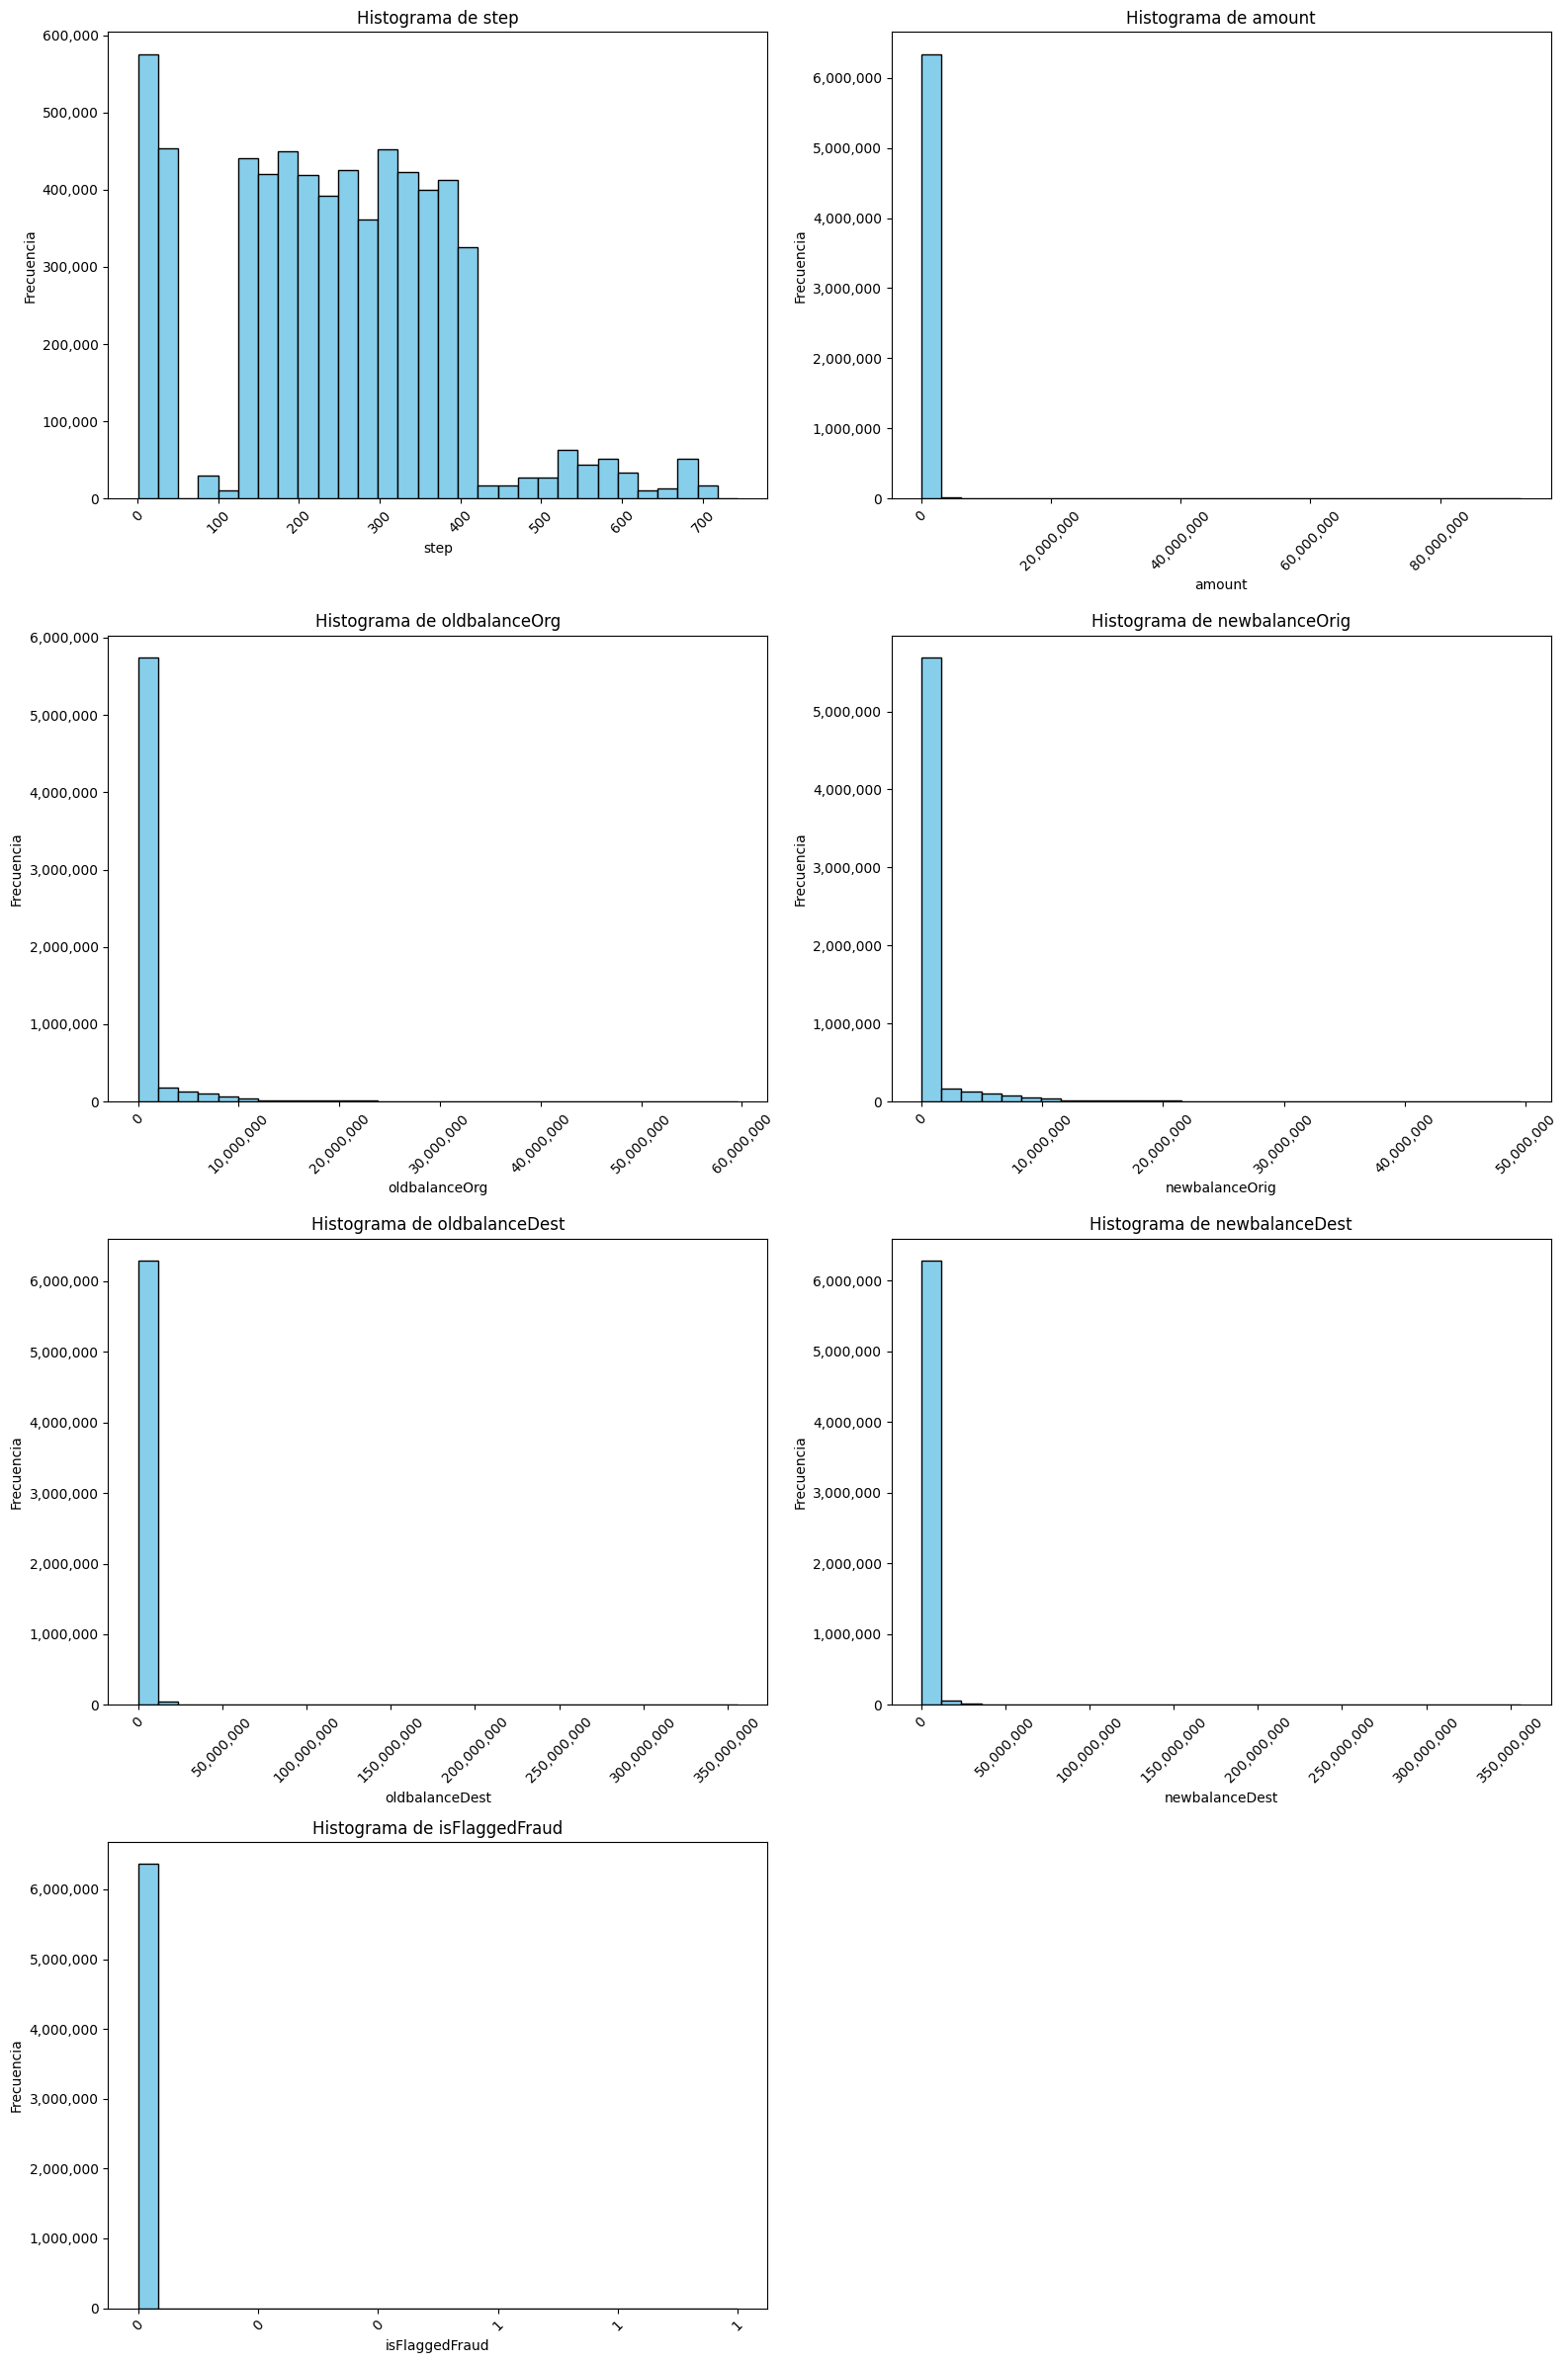

Generando gráficos de distribución para variables categóricas con menos de 20 clases...


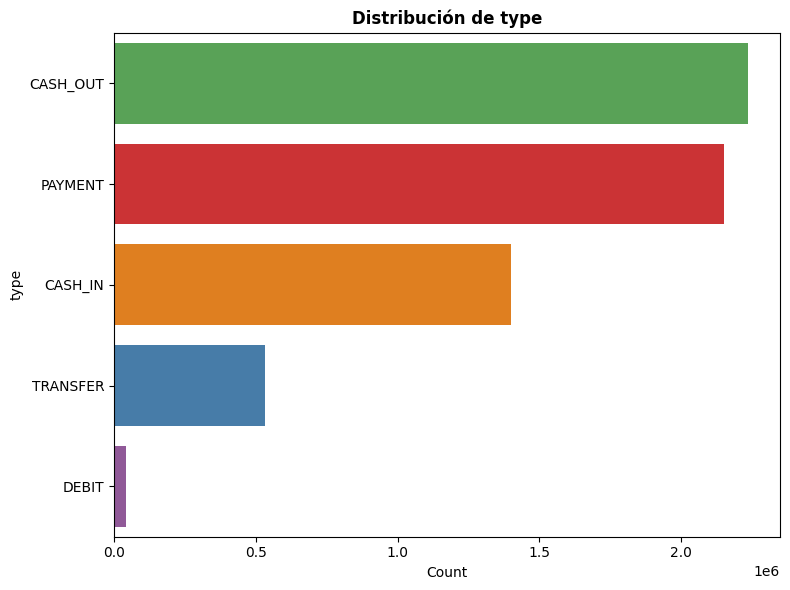

Generando gráficos de distribución por 'isFraud' para variables categóricas con menos de 20 clases...


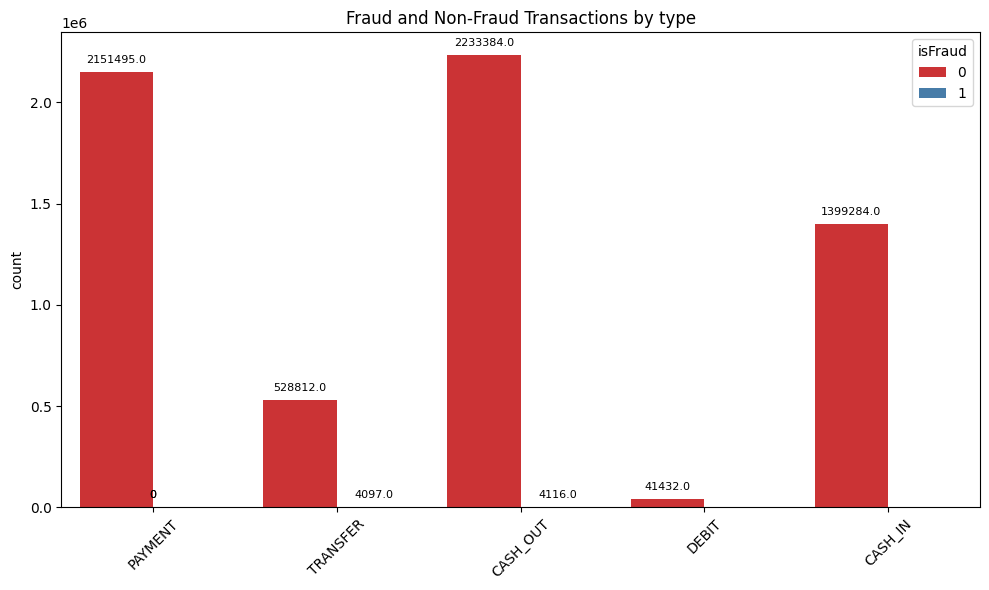

Generando boxplots por 'isFraud' para variables numéricas...


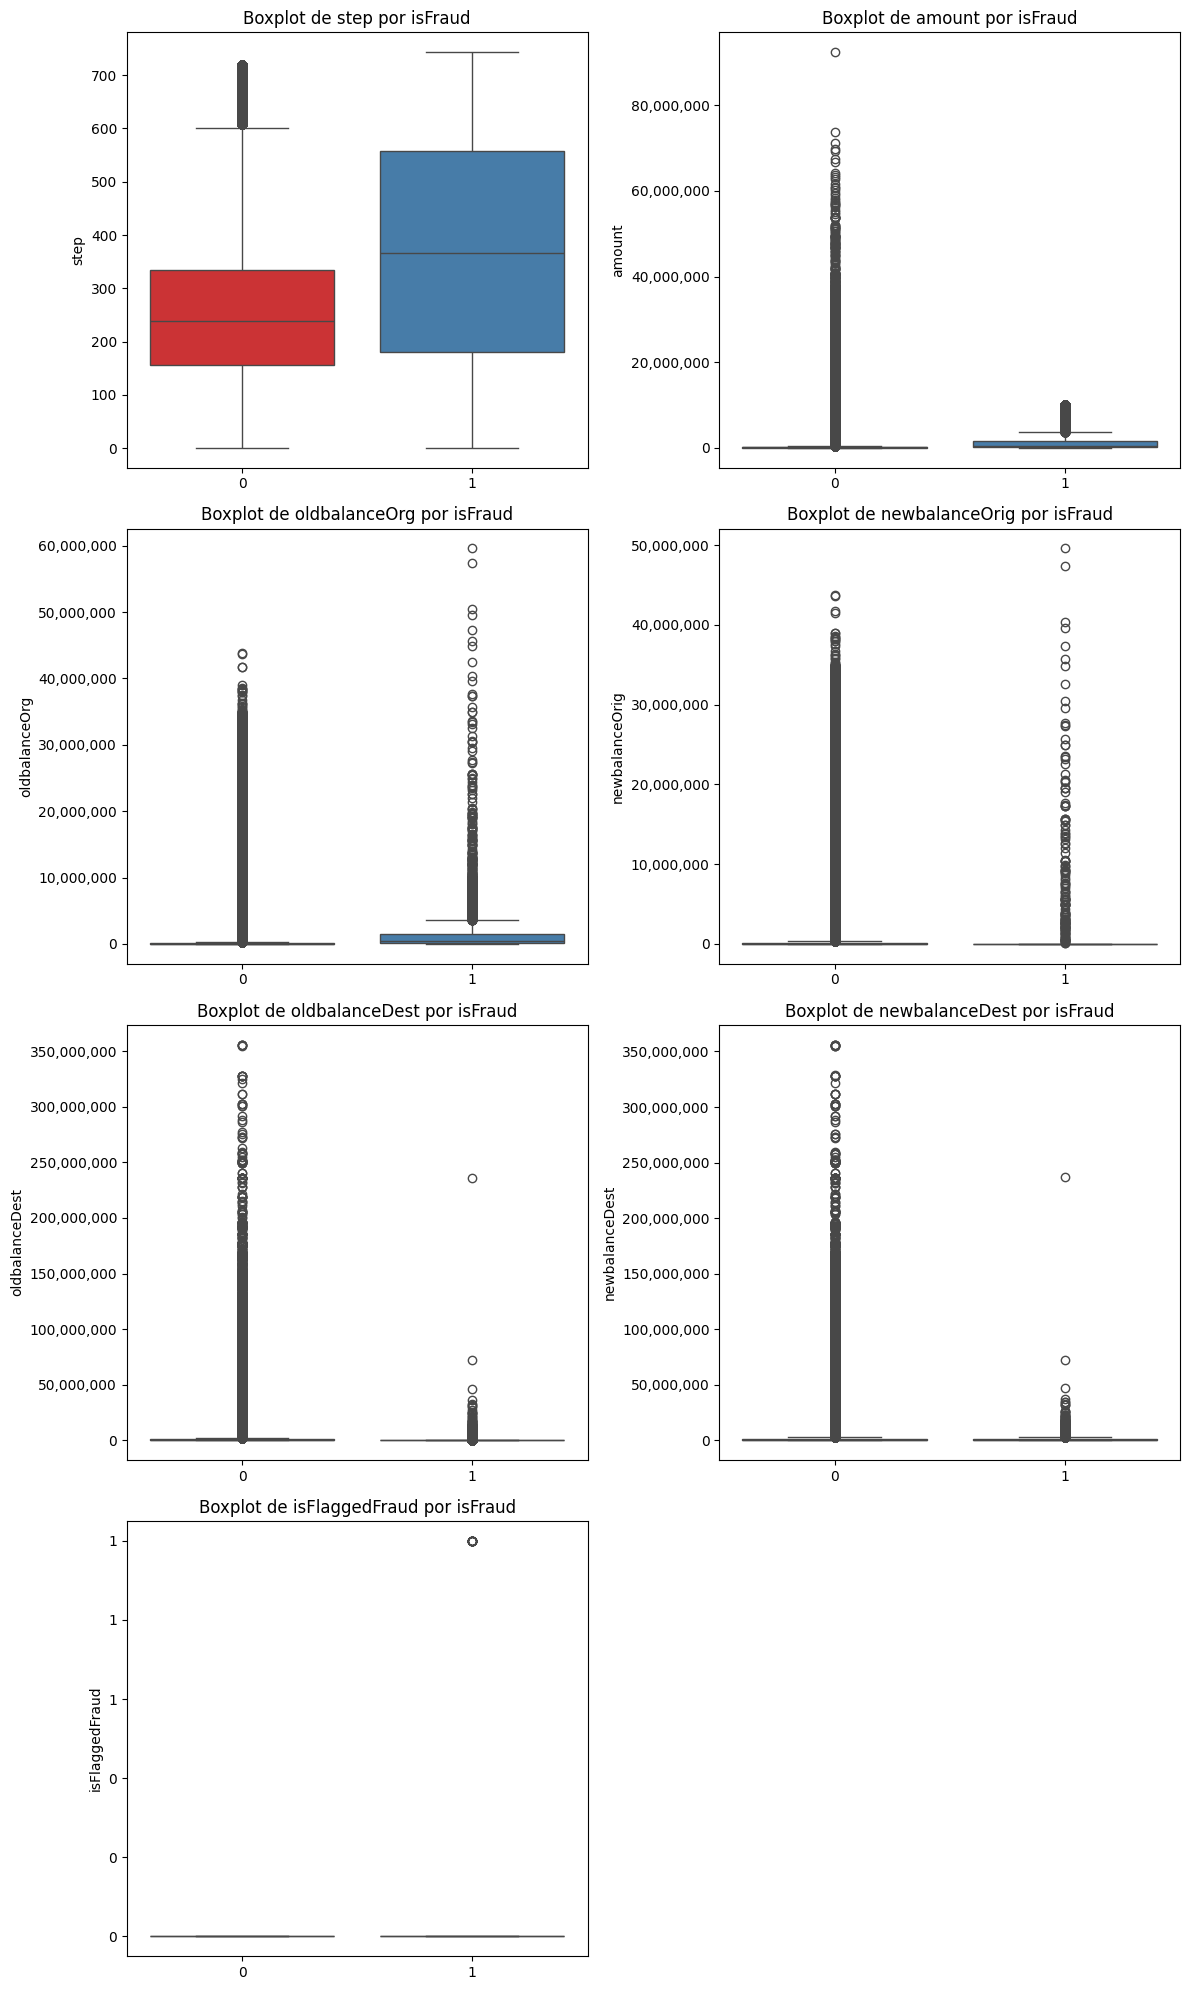

In [39]:
Visualizaciones(datos,v_obj)

Conclusiones sacadas las análisis visual:

- De la visualización de los histogramas, vemos como para casi todas las variables, existen valores muy alejados de la media, siendo step la excepción. Normalmente la inmensa heterogeneidad se encuentran en las variables de balances bancarios (estarán mezclados particulares y empresas).
- De los boxplots confirmamos lo dicho anteriormente, existen muchísimos valores atípicos por la gran heterogeneidad de los que poseen las cuentas bancarias.

- De las variables categóricas, vemos como las transacciones se agrupan en CASH_OUT, PAYMENT Y CASH_IN sobre todo, y que si relacionamos las variables categóricas con el fraude, vemos como únicamente se produce el fraude en las transacciones de tipo TRANFER y CASH_OUT, con 4097 transacciones fraudulentas en TRANFER y 4116 en CASH_OUT

### Data Cleaning

A la hora de imputar valores faltantes, es importante saber que si estos son elevados en nuestrso dataset, imputar un numero muy grande de valores faltantes puede distorsionar el análisis, si son pocos datos faltantes, pueden eliminarse, o lo que hago yo a continuación, que es imputarlos con la media o la moda.
Algunos algoritmos son capaces de gestionar de forma nativa este problema, como XGBoost y LightGBM

In [40]:
# Imputamos los valores faltantes y elminamos los duplicados
def imputacion(datos):
    # Calcula el número de filas con datos nulos antes de la imputación
    datos_nulos = datos.isnull().any(axis=1).sum()
    # Imputación de valores nulos con la media para columnas numéricas
    for col in datos.select_dtypes(include=[np.number]).columns:
        datos[col].fillna(datos[col].mean(), inplace=True)
    # Imputación de valores nulos con la moda para columnas categóricas
    for col in datos.select_dtypes(include=[object, 'category']).columns:
        datos[col].fillna(datos[col].mode()[0], inplace=True)   

    # Eliminar valores duplicados
    dupli_a = datos.shape[0]
    datos = datos.drop_duplicates()
    dupli_d = datos.shape[0]
    filas_eliminadas = dupli_a - dupli_d
    print(f"Se han imputado datos en {datos_nulos} filas.")
    print(f"Se han eliminado {filas_eliminadas} filas duplicadas.")
    
    return datos

In [41]:
datos = imputacion(datos)

Se han imputado datos en 0 filas.
Se han eliminado 0 filas duplicadas.


Como vimos en el análisis inicial, no existen valores faltantes, por lo que no se imputa ningún dato. Tampoco existen valores duplicados.

### Feature engineering

Podemos crear una nueva columna a partir de las columnas nameOrig y nameDest para saber la dirección de las transacciones, es decir cliente a cliente, de cliente a comerciante, de comerciante a cliente o de comerciante a comerciante. Esto se intuye por la primera letra en la que empiezan las columnas. C = Costumer, M = Merchant

Eliminamos después las columnas originales


In [5]:
# Función para crear la nueva columna 'transaction'
def create_transaction(row):
    return row['nameOrig'][0] + row['nameDest'][0]

# Aplicar la función para crear la nueva columna
datos['transaction'] = datos.apply(create_transaction, axis=1)
# Eliminamos las columnas originales
datos.drop(columns=['nameOrig', 'nameDest'], inplace=True)

### Modeling

En la fase de modelado vamos a crear un modelo de ML, en este caso, un Random Forest.

- Valores de entrada: Los datos después de las fases de limpieza e ingeniería de características
- Valores de salida: El modelo final entrenado, junto con un conjunto de test para después los resultados.

##### Entrenamiento
- Se separan los datos en train y test, y se estratifica para asegurarnos que la variable objetivo este bien distribuida en ambos conjuntos.

- Realizamos un pipeline de preprocesado y modelo, este pipe incluye la estandarización de las variables numéricas y onehot encoding para las categóricas, además se incluye el modelo de RF para ahorrar pasos.

- Se utiliza RandomizedSearchCV para buscar los mejores hiperparámetros, no se ajustan muchos por no alargar el calculo al ser tanto datos. Solo se realizan 4 iteraciones de combinaciones de hiperparámetros, pero lo normal sería probar más valores de hiperparámetros y más iteraciones, siempre que tengamos los recursos y el tiempo.
- Se utiliza RepeatedKFold como método de validación
- Se utiliza multiprocessing para sacar provecho de la paralelizacion
- Se utiliza "roc_auc" como métrica de evaluación, es más útil ya que tenemos las clases desbalanceadas, también podría usarse recall para optimizar la detección de transacciones fraudulentas.

Finalmente se entrena el grid y se selecciona el modelo con mejores resultados.


In [15]:
def ML_Training(datos, v_obj):
    # Reparto de datos en train y test
    # ==============================================================================
    X_train, X_test, y_train, y_test = train_test_split(
                                        datos.drop(v_obj, axis = 'columns'),
                                        datos[v_obj],
                                        train_size   = 0.8,
                                        random_state = 123,
                                        stratify=datos[v_obj]
                                    )

    
    # Preprocesado de las variables
    # ==============================================================================
    # Identificación de columnas numéricas y categóricas
    numeric_cols = X_train.select_dtypes(include=['float64', 'int']).columns.to_list()
    cat_cols = X_train.select_dtypes(include=['object', 'category']).columns.to_list()
    
    # Transformaciones para las variables numéricas
    numeric_transformer = Pipeline(
        steps=[('scaler', StandardScaler())]
    )
    
    # Transformaciones para las variables categóricas
    categorical_transformer = Pipeline(
        steps=[('onehot', OneHotEncoder(handle_unknown='ignore', sparse_output=False))]
    )
    
    preprocessor = ColumnTransformer(
        transformers=[
            ('numeric', numeric_transformer, numeric_cols),
            ('cat', categorical_transformer, cat_cols)
        ],
        remainder='passthrough',
        verbose_feature_names_out=False
    ).set_output(transform="pandas")
    
    # Se combinan los pasos de preprocesado y el modelo en un mismo pipeline.
    pipe = Pipeline([('preprocessing', preprocessor),
                     ('modelo', RandomForestClassifier(random_state = 123))])
    
    # Espacio de búsqueda de cada hiperparámetro
    param_distributions = {
        'modelo__n_estimators': [10, 15],
        'modelo__max_features': [3, 5]
    }
    
    # Búsqueda random grid
    grid = RandomizedSearchCV(
        estimator=pipe,
        param_distributions = param_distributions,
        scoring='roc_auc', 
        n_iter     = 4,
        n_jobs=multiprocessing.cpu_count() - 1,
        cv=RepeatedKFold(n_splits = 3, n_repeats = 2),
        refit=True,
        verbose=0,
        random_state = 123,
        return_train_score=True
    )
    
    # Entrenamos el modelo con las combinaciones de hiperparametros
    grid.fit(X=X_train, y=y_train)
    
    # Resultados del grid
    resultados = pd.DataFrame(grid.cv_results_)
    resultados.filter(regex='(param.*|mean_t|std_t)')\
        .drop(columns='params')\
        .sort_values('mean_test_score', ascending=False)\
        .head(1)
    
    # Imprimir el mejor modelo
    print(f"Mejores parámetros: {grid.best_params_}")
    print(f"Mejor score de AUC: {grid.best_score_}")
    
    # Modelo con mejores resultados
    modelo_final = grid.best_estimator_
    
    return(modelo_final, X_test, y_test)

La función ML_Results realiza las predicciones sobre el conjunto de test y extrae el resultado de las métricas, así como la matriz de confusión y el gráfico ROC.

- Valores de entrada: El modelo final, el conjunto de test y el nombre de la variable objetivo.
- Valores de salida: El dataframe original con los resultados de la prediccion, usado despues para el monitoreo.

In [16]:
def ML_Results(modelo_final, X_test, y_test,v_obj):

       # Predicciones sobre el conjunto de test
       y_pred = modelo_final.predict(X=X_test)
       y_pred_proba = modelo_final.predict_proba(X_test)[:, 1]
       # Creamos un dataframe con los resultados para despues el monitoreo
       resultados = X_test.copy()
       resultados[v_obj] = y_test
       resultados["y_pred"] = y_pred
       resultados["y_pred_proba"] = y_pred_proba
       
       mat_confusion = confusion_matrix(y_true=y_test, y_pred=y_pred)
       accuracy = accuracy_score(y_true=y_test, y_pred=y_pred, normalize=True)
       print("Matriz de confusión")
       print("-------------------")
       print(mat_confusion)
       print("")
       print(f"El accuracy de test es: {100 * accuracy} % \n")
       fig, ax = plt.subplots(figsize=(3, 3))
       ConfusionMatrixDisplay(mat_confusion).plot(ax=ax)
       
       print(
           classification_report(
               y_true = y_test,
               y_pred = y_pred
           )
       )
       
       # Calcular la curva ROC y el AUC
       fpr, tpr, _ = roc_curve(y_test, y_pred_proba)
       roc_auc = auc(fpr, tpr)
       # Mostrar la curva ROC
       plt.figure()
       plt.plot(fpr, tpr, color='darkorange', lw=2, label=f'Curva ROC (área = {roc_auc:.2f})')
       plt.plot([0, 1], [0, 1], color='navy', lw=2, linestyle='--')
       plt.xlim([0.0, 1.0])
       plt.ylim([0.0, 1.05])
       plt.xlabel('Tasa de Falsos Positivos')
       plt.ylabel('Tasa de Verdaderos Positivos')
       plt.title('Curva ROC')
       plt.legend(loc="lower right")
       plt.show()
       
       return(resultados)
       

In [17]:
modelo_final, x_test, y_test = ML_Training(datos, v_obj)

Mejores parámetros: {'modelo__n_estimators': 15, 'modelo__max_features': 5}
Mejor score de AUC: 0.9765262846426368


El modelo resultante consigue una puntuación de AUC de 0.97, un valor muy decente, ya que el valor perfecto para esta métrica es 1, aunque hay que verlo en más detalle para ver que tal ha conseguido clasificar los casos fraudulentos.

Matriz de confusión
-------------------
[[1270846      35]
 [    304    1339]]

El accuracy de test es: 99.97336003093066 % 

              precision    recall  f1-score   support

           0       1.00      1.00      1.00   1270881
           1       0.97      0.81      0.89      1643

    accuracy                           1.00   1272524
   macro avg       0.99      0.91      0.94   1272524
weighted avg       1.00      1.00      1.00   1272524



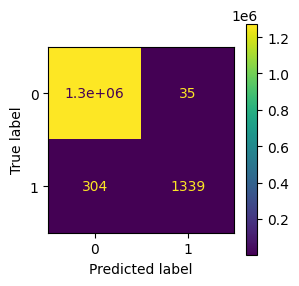

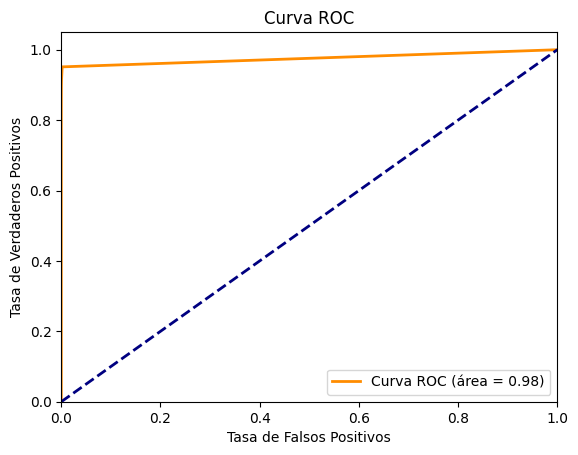

In [18]:
resultados = ML_Results(modelo_final,x_test,y_test,v_obj)

El valor de recall es 0.81, lo que significa que hemos conseguido sobre el conjunto de test, clasificar correctamente el 81% de las transacciones fraudulentas (Verdaderos positivos), 1339 de 1643, mientras 304 se nos han escapado, ya que el algoritmo los ha clasificado como no fraudulentas cuando lo son (Falsos negativos)

### Monitoring

Por último, vamos a ver una forma de monitorear el modelo mediante la librería Nannyml, esta librería ofrece herramientas para monitorear el rendimiento del modelo, detectar cambios en los datos o en las distribuciones del modelo, es decir, detecta problemas de Data Drift y permite tomar medidas correctivas cuando se detectan desviaciones.

En este pequeño ejemplo solo vamos a mostrar como es el rendimiento del modelo. Para ello se utilizan dos conjuntos de datos, un conjunto de datos denominado de 'referencia' y un conjunto de datos de 'análisis', el primero representa los datos iniciales con los que se testó el modelo (nuestro conjunto de test), el segundo representa un conjunto de datos recientes, no vistos antes, en nuestro caso, como no tenemos acceso a información nueva, simplemente simulamos parte de los datos que tenemos como conjunto de análisis.
Básicamente estimamos el rendimiento de nuestro modelo en base a la métrica o métricas que decidamos, en nuestro caso, al ser un problema de clasificación binaria, y al igual que hicimos al entrenar el modelo, usamos AUC para evaluar que tal rinde nuestro modelo.

In [19]:
def Monitoring(modelo_final, resultados,v_obj):
    X_prod, _ = train_test_split(datos, train_size=0.1, stratify=datos[v_obj], random_state=123)
    # Crear conjunto de analisis
    X_prod['y_pred'] = modelo_final.predict(X_prod)
    X_prod['y_pred_proba'] = modelo_final.predict_proba(X_prod)[:, 1]
    analysis = X_prod.copy()
    
    # Configuramos el estimador para evaluar el rendimiento
    estimator = nannyml.CBPE(
        problem_type='classification_binary',
        y_pred_proba='y_pred_proba', # Probabilidades predichas por el modelo
        y_true = v_obj, # Etiquetas reales de los datos
        y_pred = 'y_pred', # Predición realizada de los datos
        metrics = ['roc_auc'],
        chunk_size = 10000 # Los datos se procesaran en bloques de 10000 datos
    )
    
    # Se calculan las metricas en el conjunto de referencia
    estimator.fit(resultados) 
    
    # Se estima el rendimiento del modelo en el conjunto de análisis
    estimated_results = estimator.estimate(analysis) 
    
    # Lo representamos visualmente
    figure = estimated_results.plot()
    figure.show()

In [20]:
Monitoring(modelo_final,resultados,v_obj)

La gráfica de arriba tiene dos secciones, el rendimiento del conjunto de referencia y el rendimiento del conjunto de análisis, existe un umbral y los valores dados de la métrica AUC, si algún valor estimado superase el umbral, NannyML lo marcaria como alerta. En nuestro caso no tenemos ninguna alerta, pero si tuviéramos acceso a datos nuevos, y a lo largo del tiempo empiezan a saltar alertas, podría ser indicativo de tener que revisar el modelo.

Una implementación ideal de monitoreo del modelo sería ver estos gráficos en tiempo real e ir realizando un seguimiento del rendimiento y de otros problemas que puedan surgir relacionados con cambios en los datos.